## Hyperparam

In [1]:
block_size = 140
# max_len = 20
batch_size = 64
n_layer = 8 
n_head = 8 
n_embd = 256
max_epochs = 10

## Import

In [2]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

# from flattenV3Advanced import flattenData

# make deterministic
from minGPT.mingpt.utils import set_seed
set_seed(42)

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
device = torch.cuda.current_device()

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from datetime import datetime
import math
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchtext.data.metrics import bleu_score

from minGPT.mingpt.model import GPT, GPTConfig
# from minGPT.mingpt.trainer import Trainer, TrainerConfig
# from minGPT.mingpt.utils import sample
from torch.utils.data.dataloader import DataLoader

from tqdm import tqdm
import random
import pandas as pd
import string
import re
import os
import time

import logging

logger = logging.getLogger(__name__)



from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit import Chem
from rdkit.rdBase import BlockLogs
block = BlockLogs() ## not sure we want to block all but rdkit complain when wrong smiles are sent...

## dataset path
data_path = '/home/teleport/perso/2pc_cleaned.csv'
EXPERIMENT = '20201209_DF_gpt_smiles'
experiment_path = "/opt/data/train_dir/" + EXPERIMENT + "/"
# if not os.path.exists(experiment_path):
#     os.mkdir(experiment_path)

%matplotlib inline

12/10/2020 14:05:43 - INFO - rdkit -   Enabling RDKit 2020.09.1 jupyter extensions


## Trains and tensorboard

In [3]:
# now = datetime.now()
# writer = SummaryWriter(experiment_path + '/' + now.strftime("%Y%m%d-%H%M%S") + "/")
# from trains import Task
# import trains
# task = Task.init(project_name='gpt_smiles', task_name=EXPERIMENT)

## Dataset

In [4]:
data = pd.read_csv(data_path)
data.columns

Index(['smiles', 'mwt', 'logp', 'n_atoms', 'MolFormula', 'l', 'CHNO',
       'l_MolFormula', 'l_chunk', 'train'],
      dtype='object')

In [5]:
data_train = data[data['train'] == True].reset_index()
data_test = data[data['train'] == False].reset_index()
print(len(data))
print(len(data_train))
print(len(data_test))

8659463
8605866
53597


## word list

In [6]:
word_list = ['C','c','N','n','O','o','H','[',']','(',')','-','+','=','@','/','\\','#','$','&']
word_list += list(string.digits)
stoi = { ch:i for i,ch in enumerate(word_list) }
itos = { i:ch for i,ch in enumerate(word_list) }

## Helper functions for checking the smiles and tokenize them, detokenize them

In [93]:
def tokenize_idx(data, idx, stoi, block_size = None, stop_token = '$', split_token = '&'):
    return tokenize_smiles(data['smiles'][idx],data['MolFormula'][idx], stoi, block_size=block_size, stop_token = '$', split_token = '&')

def tokenize_smiles(smiles, molecular_formula, stoi, block_size = None, stop_token = '$', split_token = '&'):
    chunk = molecular_formula + split_token + smiles + stop_token
    if block_size is not None:
        chunk = chunk + stop_token*(block_size - len(chunk))
    data = [stoi[s] for s in chunk]
    return data

def y_to_completion(y, itos):
    return ''.join([itos[int(i)] for i in y])
    

def check_completion(completion, stop_token = '$', split_token = '&'):
    '''
    return a string with the status of the check:
    full_failure: cannot process it at all
    smiles_failure: MolFromSmiles return None
    MolFormula_failure: CalcMolFormula from the smile is different
    success: CalcMolFormula from the smile is same
    '''
    
    try:
        completion = completion.split(split_token)
        MolFormula = completion[0]
        smiles = completion[1].split(stop_token)[0]
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return 'smiles_failure'
        MolFormula_smiles = CalcMolFormula(mol)
        if MolFormula != MolFormula_smiles:
            return 'MolFormula_failure'
        return 'success'
    except:
        return 'full_failure'

def completion_to_pandas(completion):
    smiles = []
    MolFormulaInput = []
    MolFormulaOutput = []
#     logpInput = []
    logpOutput = []
    for i in completion:
#         print(i)
        i = i.split(split_token)
        MolFormulaInput.append(i[0])
        smile = i[1].split(stop_token)[0]
        smiles.append(smile)
        mol = Chem.MolFromSmiles(smile)
        if mol is None:
            MolFormulaOutput.append('fail')
            logpOutput.append('fail')
        else:
            MolFormulaOutput.append(CalcMolFormula(mol))
            logpOutput.append(Descriptors.MolLogP(mol))
    df = pd.DataFrame(list(zip(logpOutput,MolFormulaInput, smiles,logpOutput, MolFormulaOutput)), 
               columns =['logpInput','MolFormulaInput', 'smiles', 'logpOutput', 'MolFormulaOutput']) 
    PandasTools.AddMoleculeColumnToFrame(df,smilesCol='smiles')
    return(df)

def check_df(df):
    df2 = df[df['MolFormulaOutput'] != 'fail']
    smiles_failure_ratio = (len(df) - len(df2))/len(df)
    MolFormula_success = sum(df2['MolFormulaInput'] == df2['MolFormulaOutput'])/len(df)
    MolFormula_failure = sum(df2['MolFormulaInput'] != df2['MolFormulaOutput'])/len(df)
    logp_mse = mean_squared_error(df2['logpInput'],df2['logpOutput'])
    return {'smiles_failure_ratio':smiles_failure_ratio, 
            'MolFormula_failure':MolFormula_failure,
           'MolFormula_success':MolFormula_success,
           'logp_mse':logp_mse}

In [8]:
y = tokenize_idx(data_test, 0, stoi)
completion = y_to_completion(y, itos)

check_completion(completion)

'success'

In [9]:
completion = 'C23H39N5O&CN(C)c1ccc(CNC(=O)CN2CCC(C)(CN3CCN(C)CC3)CC2)cc1'
check_completion(completion)

'success'

## Dataloader

In [10]:
class SmilesDataset(Dataset):

    def __init__(self, data, block_size, stoi, itos):
        
        self.data = data
        self.stoi = stoi
        self.itos = itos
        self.block_size = block_size
        self.vocab_size = len(self.stoi)
        
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx,verbose=False):
        converted_chunk = tokenize_idx(self.data, idx, self.stoi, self.block_size)
            
        x = torch.tensor(converted_chunk[:-1], dtype=torch.long)
        y = torch.tensor(converted_chunk[1:], dtype=torch.long)
        return x, y
            
train_dataset = SmilesDataset(data_train, block_size, stoi, itos) 
test_dataset = SmilesDataset(data_test, block_size, stoi, itos) 

df = train_dataset.__getitem__(idx = 10,verbose=True)

## Model declaration

In [11]:
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=n_layer, n_head=n_head, n_embd=n_embd)
model = GPT(mconf)
# model.load_state_dict(torch.load(experiment_path + 'model_0.pt'))

12/10/2020 14:06:10 - INFO - minGPT.mingpt.model -   number of parameters: 6.369792e+06


## Sample function

In [68]:
def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

@torch.no_grad()
def sample_clean(model, xs, steps, temperature=1.0, sample=False, top_k=None, itos = None, stop_token = '$',batch_size = 4):
#     block_size = model.get_block_size()
    model.eval()
    xs = sorted(xs, key = lambda x: x.size(1))
    ## add the batch size
    xs = [torch.cat(batch_size*[x]) for x in xs]
    
    ## start by making them the same length
    x = xs[0]
    for i in range(1,len(xs)): # nothing to do if length 1
        while x.size(1) < xs[i].size(1):
            x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
            logits, _ = model(x_cond)
            # pluck the logits at the final step and scale by temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop probabilities to only the top k options
            if top_k is not None:
                logits = top_k_logits(logits, top_k)
            # apply softmax to convert to probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution or take the most likely
            if sample:
                ix = torch.multinomial(probs, num_samples=1)
            else:
                _, ix = torch.topk(probs, k=1, dim=-1)
            # append to the sequence and continue
            x = torch.cat((x, ix), dim=1)
        x= torch.cat((x,xs[i]), dim=0)
    
    
    ## now we can keep going...
    keep_going = True
    while keep_going:
#         print(x.size(1))
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        logits, _ = model(x_cond)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)
        # append to the sequence and continue
        x = torch.cat((x, ix), dim=1)
        if x.size(1) == block_size:
            keep_going = False
        if itos is not None:
            sequences_over = 0
            for i in range(x.size(0)):                
                if itos[int(ix[i])] == stop_token:
                    sequences_over += 1
            if sequences_over == x.size(0):
                keep_going = False
    return x

def check_model_output(model, MolFormulas, stop_token = '$', split_token = '&', batch_size = 4,temperature=0.9):
    results = []
    completions = []
    for i in MolFormulas:        
        data = [stoi[s] for s in i + split_token]
        x = [torch.tensor(data, dtype=torch.long).unsqueeze(0).to(device)]
        y = sample_clean(model, x, steps = block_size, temperature=temperature, sample=True, top_k=5, itos = itos, stop_token = '$', batch_size = batch_size)
        for idx in range(y.size(0)):    
            completion = y_to_completion(y[idx], itos)
            completions.append(completion)
            results.append(check_completion(completion))
            
    return results, completions

## Training loop

In [13]:
# class TrainerConfig:
#     # optimization parameters
#     max_epochs = 10
#     batch_size = 64
#     learning_rate = 3e-4
#     betas = (0.9, 0.95)
#     grad_norm_clip = 1.0
#     weight_decay = 0.1 # only applied on matmul weights
#     # learning rate decay params: linear warmup followed by cosine decay to 10% of original
#     lr_decay = False
#     warmup_tokens = 375e6 # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
#     final_tokens = 260e9 # (at what point we reach 10% of original LR)
#     # checkpoint settings
#     ckpt_path = None
#     num_workers = 0 # for DataLoader

#     def __init__(self, **kwargs):
#         for k,v in kwargs.items():
#             setattr(self, k, v)

# class Trainer:

#     def __init__(self, model, train_dataset, test_dataset, config):
#         self.model = model
#         self.train_dataset = train_dataset
#         self.test_dataset = test_dataset
#         self.config = config

#         # take over whatever gpus are on the system
#         self.device = 'cpu'
#         if torch.cuda.is_available():
#             self.device = torch.cuda.current_device()
#             self.model = torch.nn.DataParallel(self.model).to(self.device)

#     def save_checkpoint(self):
#         # DataParallel wrappers keep raw model object in .module attribute
#         raw_model = self.model.module if hasattr(self.model, "module") else self.model
#         logger.info("saving %s", self.config.ckpt_path)
#         torch.save(raw_model.state_dict(), self.config.ckpt_path + 'model.pt')

#     def train(self, writer):
#         model, config = self.model, self.config
#         raw_model = model.module if hasattr(self.model, "module") else model
#         optimizer = raw_model.configure_optimizers(config)

#         def run_epoch(split):
#             is_train = split == 'train'
#             model.train(is_train)
#             data = self.train_dataset if is_train else self.test_dataset
#             loader = DataLoader(data, shuffle=True, pin_memory=True,
#                                 batch_size=config.batch_size,
#                                 num_workers=config.num_workers)

#             losses = []
#             pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
#             for it, (x, y) in pbar:

#                 # place data on the correct device
#                 x = x.to(self.device)
#                 y = y.to(self.device)

#                 # forward the model
#                 with torch.set_grad_enabled(is_train):
#                     logits, loss = model(x, y)
#                     loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
#                     losses.append(loss.item())

#                 if is_train:

#                     # backprop and update the parameters
#                     model.zero_grad()
#                     loss.backward()
#                     torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
#                     optimizer.step()

#                     # decay the learning rate based on our progress
#                     if config.lr_decay:
#                         self.tokens += (y >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
#                         if self.tokens < config.warmup_tokens:
#                             # linear warmup
#                             lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens))
#                         else:
#                             # cosine learning rate decay
#                             progress = float(self.tokens - config.warmup_tokens) / float(max(1, config.final_tokens - config.warmup_tokens))
#                             lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
#                         lr = config.learning_rate * lr_mult
#                         for param_group in optimizer.param_groups:
#                             param_group['lr'] = lr
#                     else:
#                         lr = config.learning_rate

#                     # report progress
#                     pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. lr {lr:e}")

#             if not is_train:
#                 test_loss = float(np.mean(losses))
#                 logger.info("test loss: %f", test_loss)
#                 return test_loss
#             else:
#                 train_loss = float(np.mean(losses))
#                 return train_loss

#         best_loss = float('inf')
#         self.tokens = 0 # counter used for learning rate decay
#         for epoch in range(config.max_epochs):

#             train_loss = run_epoch('train')
#             writer.add_scalar('loss/train_loss',train_loss,epoch)
#             if self.test_dataset is not None:
#                 test_loss = run_epoch('test')
#                 writer.add_scalar('loss/test_loss',test_loss,epoch)
                
#                 MolFormulas = list(self.test_dataset.data['MolFormula'].unique())    
#                 results, completions = check_model_output(model, MolFormulas, batch_size = 16)  
#                 for i in ['success','MolFormula_failure','smiles_failure','full_failure']:
#                     writer.add_scalar('results/'+i,results.count(i)/len(results),epoch)

#             # supports early stopping based on the test loss, or just save always if no test set is provided
#             good_model = self.test_dataset is None or test_loss < best_loss
#             if self.config.ckpt_path is not None and good_model:
#                 best_loss = test_loss
#                 self.save_checkpoint()


## Training

In [ ]:

# # # initialize a trainer instance and kick off training
# tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=6e-4,
#                       lr_decay=True, warmup_tokens=512*20, final_tokens=200*len(train_dataset)*block_size,
#                       num_workers=8, ckpt_path = experiment_path)
# trainer = Trainer(model, train_dataset, test_dataset, tconf)
# trainer.train(writer)

epoch 1 iter 1782: train loss 0.26802. lr 6.000000e-04:   1%|▏         | 1782/134467 [02:49<3:49:09,  9.65it/s]

TRAINS Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


epoch 1 iter 134466: train loss 0.18863. lr 5.999635e-04: 100%|██████████| 134467/134467 [3:34:20<00:00, 10.46it/s]
12/09/2020 12:43:39 - INFO - __main__ -   test loss: 0.190132
12/09/2020 12:43:55 - INFO - __main__ -   saving /opt/data/train_dir/20201209_DF_gpt_smiles/
epoch 2 iter 33838: train loss 0.18959. lr 5.999428e-04:  25%|██▌       | 33837/134467 [54:10<2:41:27, 10.39it/s]

## Test the model

In [80]:
str(round(4.21321321,1))

'4.2'

In [60]:
from rdkit.Chem import PandasTools

device = 'cpu'
stop_token = '$'
split_token = '&'

In [12]:
model.load_state_dict(torch.load(experiment_path + 'model.pt'))

<All keys matched successfully>

In [15]:
model = model.to(device)

In [73]:
results

['success',
 'MolFormula_failure',
 'success',
 'MolFormula_failure',
 'MolFormula_failure',
 'MolFormula_failure',
 'MolFormula_failure',
 'MolFormula_failure',
 'MolFormula_failure',
 'success',
 'success',
 'MolFormula_failure',
 'success',
 'success',
 'MolFormula_failure',
 'MolFormula_failure']

In [90]:
%%time
results, completion = check_model_output(model,['C15H22N2O6', 'C16H32N4O2'],batch_size=16,temperature=2)
df = completion_to_pandas(completion)

CPU times: user 28 s, sys: 184 ms, total: 28.2 s
Wall time: 7.15 s


,MolFormulaInput,smiles,MolFormulaOutput,ROMol
0,C15H22N2O6,Cc1[nH]oc(COC(=O)C[C@H](O)CC(=O)OC(C)(C)C)c1C#N,fail,None
1,C15H22N2O6,COCc1ccc(C[C@H](CO[C@H]2CNC(=O)C[C@@]2(O)COC)o1,fail,None
2,C15H22N2O6,NC(=O)[C@@H]1O[C@H]([C@@H]3COCCN3CC3(C(=O)O)[C...,C15H22N2O7,
3,C15H22N2O6,O=C(N[C@@H]1[C@@H](CO)CCCO1)C1=CC(N2CCOCC2)C(=...,C15H22N2O6,
4,C15H22N2O6,O=C(CCCON1C(=O)CCC1=O)N1CCC2(CC1)C[C@H](O)OC2,C16H24N2O6,

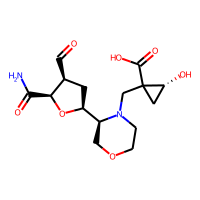
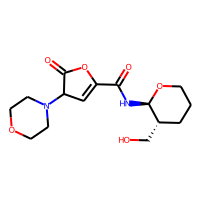
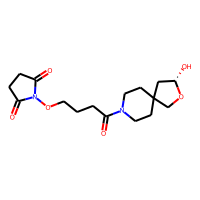

In [83]:
df.head()

In [95]:
from sklearn.metrics import mean_squared_error

# def check_df(df):
#     df2 = df[df['MolFormulaOutput'] != 'fail']
#     smiles_failure_ratio = (len(df) - len(df2))/len(df)
#     MolFormula_success = sum(df2['MolFormulaInput'] == df2['MolFormulaOutput'])/len(df)
#     MolFormula_failure = sum(df2['MolFormulaInput'] != df2['MolFormulaOutput'])/len(df)
#     return {'smiles_failure_ratio':smiles_failure_ratio, 
#             'MolFormula_failure':MolFormula_failure,
#            'MolFormula_success':MolFormula_success}
check_df(df)['logp_mse']

0.0

In [98]:
1000 % 10


0

C25H38O6
5.175400000000005


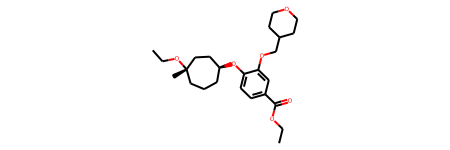

In [47]:
from rdkit.Chem import AllChem, Descriptors
smiles = 'CCOC(=O)c1ccc(O[C@H]2CCC[C@](C)(OCC)CC2)c(OCC2CCOCC2)c1'
mol = Chem.MolFromSmiles(smiles)
print(CalcMolFormula(mol))
print(Descriptors.MolLogP(mol))
mol